In [1]:
import pandas as pd
import numpy as np
from safegraph_py_functions import safegraph_py_functions as sgpy
import os
from dotenv import load_dotenv, find_dotenv
from loguru import logger

In [2]:
# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)
os.chdir(os.environ.get("ROOT_DIR"))
from src import DATA_DIR


In [3]:
clusters = pd.read_csv(DATA_DIR / 'processed' / 'sg_clusters.csv')

In [4]:
places = pd.read_csv(DATA_DIR / 'processed' / 'philly_places.csv.tar.gz', low_memory = False)

In [5]:
def get_last_vals(df, vals, id_col, date_col):
    df = df[vals + [id_col, date_col]].dropna()
    df = df.sort_values(date_col, ascending = False)
    df = df.drop(columns = date_col)
    return df.groupby(id_col).first().reset_index()

In [6]:
value_sets = [['latitude','longitude'], ['brands'], ['top_category']]
id_col = 'safegraph_place_id'
date_col = 'valid_from'
for vals in value_sets:
    values = get_last_vals(places, vals, id_col, date_col)
    clusters = clusters.merge(values, on = 'safegraph_place_id', how = 'left')

In [7]:
clusters

,safegraph_place_id,cluster,latitude,longitude,brands,top_category
0,sg:00018e7b1ba449278dd1c33a2348e5fa,1,40.106492,-75.029052,NaN,Restaurants and Other Eating Places
1,sg:0001da921b9d488986c0bdf83bfaff4b,1,40.102114,-75.031340,NaN,"Automotive Parts, Accessories, and Tire Stores"
2,sg:0003e5a379604393b0dc6e9bce0058b2,5,39.982305,-75.239359,Little Caesars,Restaurants and Other Eating Places
3,sg:0004189674c64e108e4b5ea2baa68eb9,1,39.924732,-75.169153,Popeyes Louisiana Kitchen,Restaurants and Other Eating Places
4,sg:0008547f38f54091836959120205256c,10,39.974429,-75.141649,NaN,Elementary and Secondary Schools
...,...,...,...,...,...,...
19642,sg:fff63ed550f040d3abb82f1cf68f3420,1,39.929090,-75.146995,DaVita,Outpatient Care Centers
19643,sg:fffa1e4de2334d4aaefeabf8a4ecd8a0,10,40.036797,-75.130750,NaN,Grocery Stores
19644,sg:fffd2de0819b46b2894b5ffb13122128,1,39.963748,-75.167991,NaN,Child Day Care Services
19645,sg:fffe3d31062f46d9a2a0b0eca6d0c585,1,39.946316,-75.148319,NaN,Offices of Other Health Practitioners


In [8]:
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
import hvplot.pandas
import geopandas as gpd
import urllib.request
import json
from matplotlib import pyplot as plt
import panel as pn
import param as pm

In [9]:
big_brands = clusters.groupby('brands').size().sort_values(ascending = False).index[:5]
brand_data = clusters[clusters.brands.apply(lambda x: x in big_brands)]
brand_data = brand_data.groupby(['brands','cluster']).size().reset_index()
brand_data.columns = [col for col in brand_data.columns[:2]] + ['count']
brand_data['total'] = brand_data[['brands','count']].groupby('brands').transform('sum')
brand_data['frequency'] = brand_data['count']/brand_data['total']

In [10]:
brands_df = brand_data[['brands']].drop_duplicates()
clusters_df = brand_data[['cluster']].drop_duplicates()
brands_df['key'] = 1
clusters_df['key'] = 1
combined_df = brands_df.merge(clusters_df)
combined_df.drop(columns = 'key', inplace = True)
brand_data = combined_df.merge(brand_data, on = ['cluster','brands'], how = 'left')
brand_data = brand_data.fillna(0)

In [11]:
# HK: I would like to have checkboxes for 'normalized by devices seen' and 'relative to January'
#     but don't know how to give the checkbox a name (I was looking at pm.Boolean()).
class Brand_distribution(pm.Parameterized):
    df = brand_data
    brand = pm.Selector(
        objects = big_brands,
        default = big_brands[0], allow_None = False)
    
    @pm.depends('brand')
    def make_subtitle(self):
        return 'Distribution of ' + self.brand + ' locations by cluster'
    
    @pm.depends('df', 'brand')
    def filter_brand(self):
        mask = self.df['brands'] == self.brand
        return self.df.loc[mask]
        
    @pm.depends('df', 'brand')
    def make_bar_plot(self):
        n_clusters = max(self.df.cluster)
        filtered = self.filter_brand()
        # Create the figure
        fig, ax = plt.subplots(figsize=(8, 8))
        
        # Plot
        ax.bar(filtered.cluster, filtered.frequency)

        # NEW: Set the xlims and ylims
        ax.set_xlim(-1, n_clusters+1)
        ax.set_ylim(0, 1)

        return fig

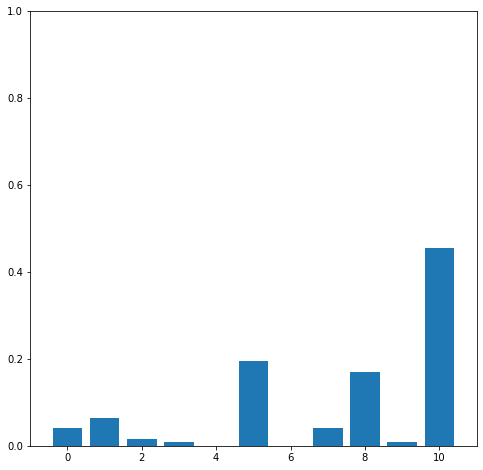

In [12]:
brand_app = Brand_distribution(name = "")
brand_title = '### Brands by cluster'
brand_panel = pn.Column(
    pn.Row(
        pn.Column(brand_title, brand_app.make_subtitle, pn.Param(brand_app.param))
    ), brand_app.make_bar_plot )

Column
    [0] Row
        [0] Column
            [0] Markdown(str)
            [1] ParamMethod(method)
            [2] Param(Brand_distribution)
    [1] ParamMethod(method)
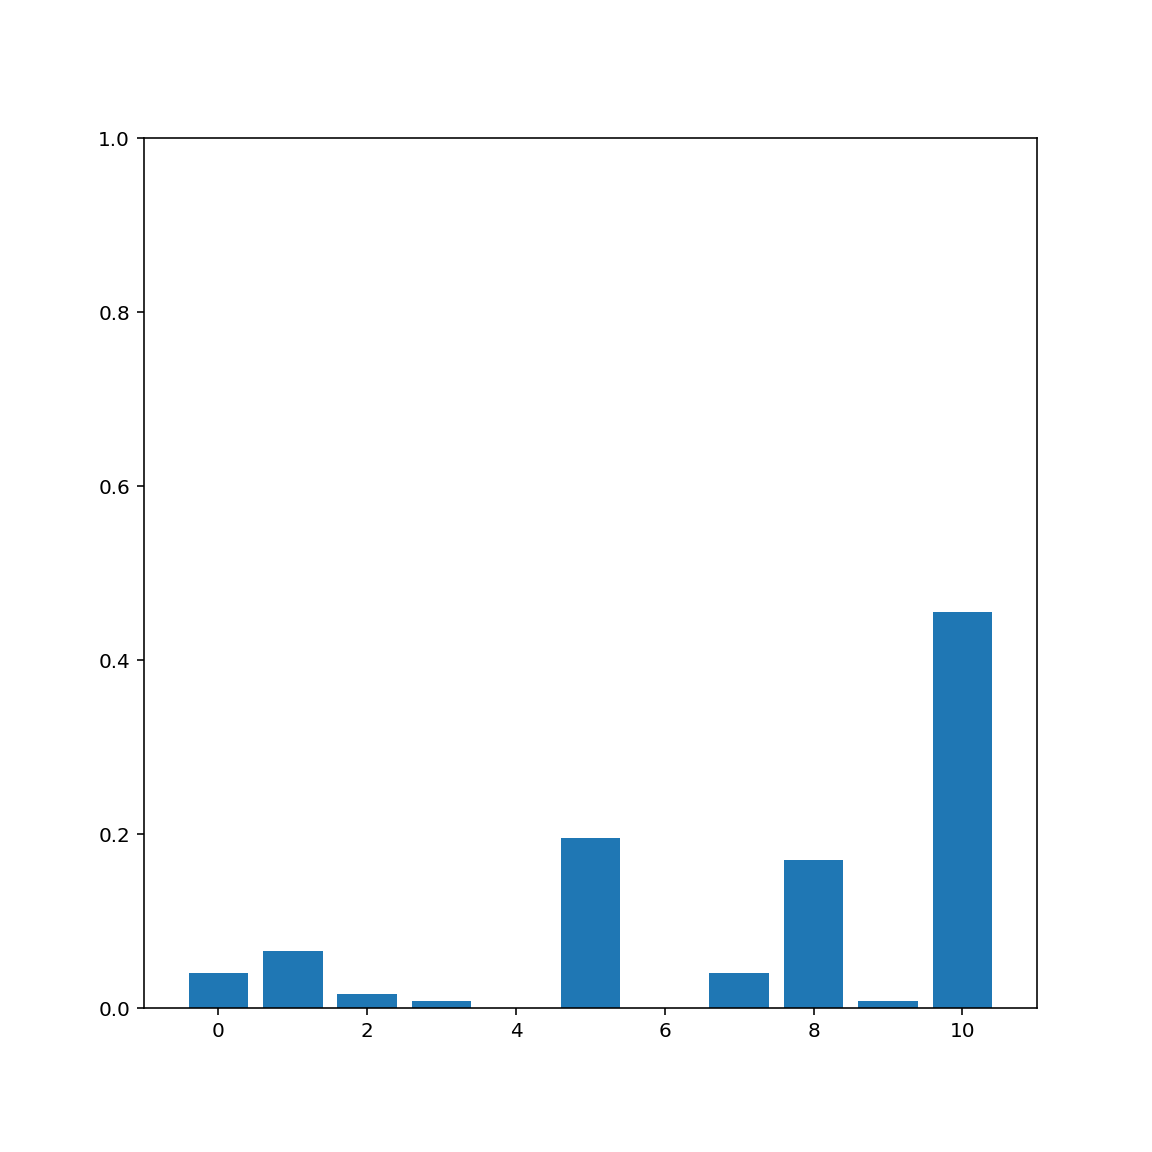

In [13]:
brand_panel

## Categories plots

In [14]:
big_cat = clusters.groupby('top_category').size().sort_values(ascending = False).index[:5]
category_data = clusters[clusters.top_category.apply(lambda x: x in big_cat)]
category_data = category_data.groupby(['top_category','cluster']).size().reset_index()
category_data.columns = [col for col in category_data.columns[:2]] + ['count']
category_data['total'] = category_data[['top_category','count']].groupby('top_category').transform('sum')
category_data['frequency'] = category_data['count']/category_data['total']

In [15]:
category_df = category_data[['top_category']].drop_duplicates()
clusters_df = category_data[['cluster']].drop_duplicates()
category_df['key'] = 1
clusters_df['key'] = 1
combined_df = category_df.merge(clusters_df)
combined_df.drop(columns = 'key', inplace = True)
category_data = combined_df.merge(category_data, on = ['cluster','top_category'], how = 'left')
category_data = category_data.fillna(0)

In [16]:
class Category_distribution(pm.Parameterized):
    df = category_data
    category = pm.Selector(
        objects = big_cat,
        default = big_cat[0], allow_None = False)
    
    @pm.depends('category')
    def make_subtitle(self):
        return 'Distribution of ' + self.category + ' locations by cluster'
    
    @pm.depends('df', 'category')
    def filter_brand(self):
        mask = self.df['top_category'] == self.category
        return self.df.loc[mask]
        
    @pm.depends('df', 'category')
    def make_bar_plot(self):
        n_clusters = max(self.df.cluster)
        filtered = self.filter_brand()
        # Create the figure
        fig, ax = plt.subplots(figsize=(8, 8))
        
        # Plot
        ax.bar(filtered.cluster, filtered.frequency)

        # NEW: Set the xlims and ylims
        ax.set_xlim(-1, n_clusters+1)
        ax.set_ylim(0, 1)

        return fig

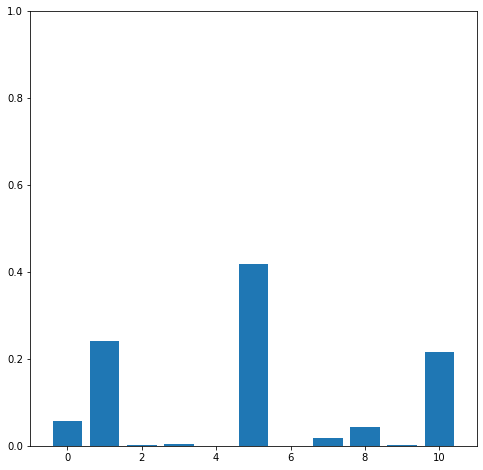

In [17]:
category_app = Category_distribution(name = "")
category_title = '### Categories by cluster'
category_panel = pn.Column(
    pn.Row(
        pn.Column(category_title, category_app.make_subtitle, pn.Param(category_app.param))
    ), category_app.make_bar_plot )

Column
    [0] Row
        [0] Column
            [0] Markdown(str)
            [1] ParamMethod(method)
            [2] Param(Category_distribution)
    [1] ParamMethod(method)
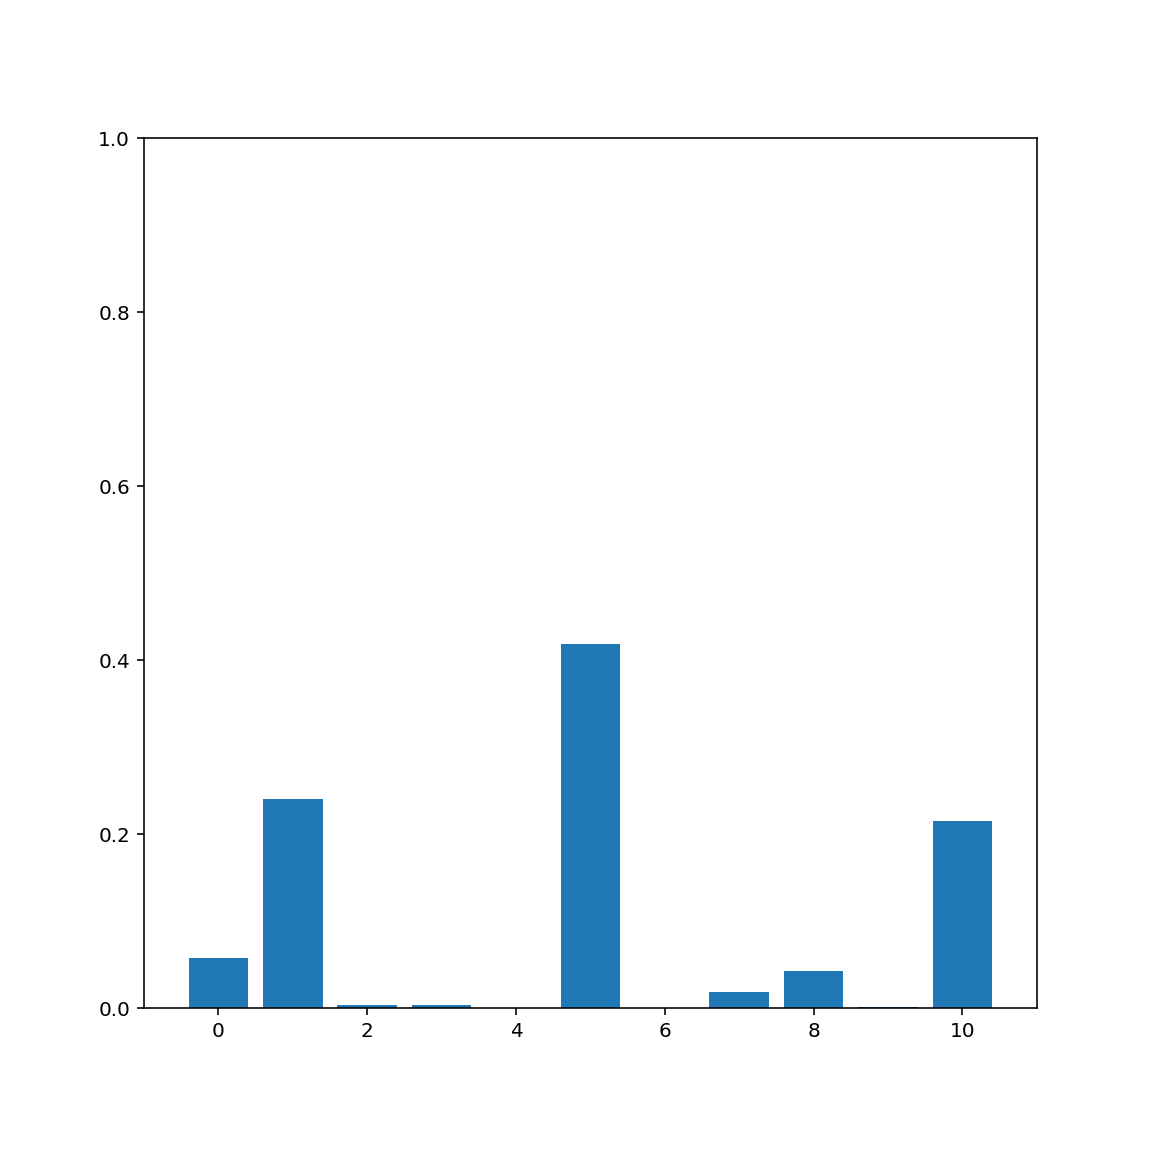

In [18]:
category_panel

In [19]:
places.sort_values('valid_from', ascending = False)

,safegraph_place_id,parent_safegraph_place_id,location_name,safegraph_brand_ids,brands,top_category,sub_category,naics_code,latitude,longitude,...,phone_number,open_hours,category_tags,valid_to,valid_from,placekey,opened_on,closed_on,tracking_opened_since,tracking_closed_since
64304,sg:ca990f5fb4514cc8b966b3c6e744c3dc,sg:4e063fa72f97420b8fc99c2b6bbe852d,Staples,SG_BRAND_a4d18fc84a927940d1294e253001ce3d,Staples,"Office Supplies, Stationery, and Gift Stores",Office Supplies and Stationery Stores,453210.0,40.031024,-75.099091,...,1.215536e+10,"{ ""Mon"": [[""8:00"", ""21:00""]], ""Tue"": [[""8:00"",...",NaN,2020-10-19,2020-09-08,zzw-222@628-pj8-p9z,NaN,NaN,NaN,NaN
71239,sg:dfc52f5da0ca4555a7e0803a9dd7b8a7,NaN,Mick Daniels,NaN,NaN,Drinking Places (Alcoholic Beverages),Drinking Places (Alcoholic Beverages),722410.0,39.921971,-75.150057,...,1.215464e+10,NaN,"Bar or Pub,Late Night",2020-10-19,2020-09-08,23w-222@628-pm6-hqz,NaN,NaN,NaN,NaN
71241,sg:fda07b7e2ab14e83ad93aeae7f387139,sg:22feac29c893479cbd20db580ba5b839,Health Street,SG_BRAND_c5c154df3c9599e7,Health Street,Medical and Diagnostic Laboratories,Medical Laboratories,621511.0,39.926347,-75.170104,...,NaN,NaN,NaN,2020-10-19,2020-09-08,226-222@628-pm4-g49,NaN,NaN,NaN,NaN
71242,sg:073eb2dbebc54464b56d04348e41f77b,NaN,Goorin Bros.,SG_BRAND_fae48665591f2eb,Goorin Bros.,Clothing Stores,Other Clothing Stores,448190.0,39.949651,-75.165376,...,1.215665e+10,"{ ""Mon"": [[""11:00"", ""20:00""]], ""Tue"": [[""11:00...",NaN,2020-10-19,2020-09-08,227-222@628-pmb-6rk,NaN,NaN,NaN,NaN
71243,sg:22f9aae979644a93b9dda3ba8540cbf5,NaN,Bridge & Pratt Family Pharmacy,NaN,NaN,Health and Personal Care Stores,Pharmacies and Drug Stores,446110.0,40.021572,-75.079003,...,1.215538e+10,NaN,NaN,2020-10-19,2020-09-08,zzy-222@628-p8m-swk,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14382,sg:53ee6625c239407b8674fbfeb3327777,NaN,Rizzo Ice Rink,NaN,NaN,Other Amusement and Recreation Industries,Fitness and Recreational Sports Centers,713940.0,39.933165,-75.145547,...,1.215685e+10,NaN,NaN,2020-03-25,1900-01-01,NaN,NaN,NaN,NaN,NaN
14383,sg:9d71dfeae49a4bd1a9bc672af75aa4bf,NaN,All Saints Episcopal School,NaN,NaN,Elementary and Secondary Schools,Elementary and Secondary Schools,611110.0,40.058462,-74.993476,...,NaN,NaN,NaN,2020-03-25,1900-01-01,NaN,NaN,NaN,NaN,NaN
14384,sg:a444d6a14d8445a2a901c13ff75d1e0b,NaN,Munlyns Munchkins Day Care,NaN,NaN,NaN,NaN,NaN,39.961807,-75.241350,...,NaN,NaN,NaN,2020-03-25,1900-01-01,NaN,NaN,NaN,NaN,NaN
14385,sg:b4b9c7be257242a1b4544826c5bc7dd2,NaN,Little Learners Learning Center,NaN,NaN,Elementary and Secondary Schools,Elementary and Secondary Schools,611110.0,40.050319,-75.067395,...,NaN,NaN,NaN,2020-03-25,1900-01-01,NaN,NaN,NaN,NaN,NaN


In [20]:
places.valid_from.unique()

array(['1900-01-01', '2020-03-25', '2020-04-07', '2020-09-08',
       '2020-06-06', '2020-08-07', '2020-07-13', '2020-05-06'],
      dtype=object)

In [21]:
places = places.groupby('safegraph_place_id').first().reset_index()

In [22]:
places.groupby('valid_from').size()

valid_from
1900-01-01    21569
2020-03-25       89
2020-04-07      123
2020-05-06       23
2020-06-06     2333
2020-07-13       36
2020-08-07       34
2020-09-08     1609
dtype: int64

In [23]:
places.head()

,safegraph_place_id,parent_safegraph_place_id,location_name,safegraph_brand_ids,brands,top_category,sub_category,naics_code,latitude,longitude,...,phone_number,open_hours,category_tags,valid_to,valid_from,placekey,opened_on,closed_on,tracking_opened_since,tracking_closed_since
0,sg:0000395ed3954bf6bce9fc48d52f3c5b,None,Lanci Bakery,None,None,Bakeries and Tortilla Manufacturing,Retail Bakeries,311811.0,39.923647,-75.175465,...,1.215463e+10,None,None,2020-07-13,2020-06-06,None,None,2020-01,None,2019-07
1,sg:00018e7b1ba449278dd1c33a2348e5fa,None,Maxi Gastronome,None,None,Restaurants and Other Eating Places,Full-Service Restaurants,722511.0,40.106492,-75.029052,...,NaN,"{ ""Mon"": [[""9:00"", ""20:00""]], ""Tue"": [[""9:00"",...","Russian Food,European Food",2020-03-25,1900-01-01,225-222@628-p9p-tgk,None,None,None,2019-07
2,sg:0001da921b9d488986c0bdf83bfaff4b,None,Carlo's Tire & Repairs,None,None,"Automotive Parts, Accessories, and Tire Stores",Automotive Parts and Accessories Stores,441310.0,40.102114,-75.031340,...,1.215465e+10,"{ ""Mon"": [[""8:00"", ""17:00""]], ""Tue"": [[""8:00"",...",None,2020-03-25,1900-01-01,zzw-223@628-p9p-qmk,None,None,None,2019-07
3,sg:0003e5a379604393b0dc6e9bce0058b2,sg:e61ba782d68d41f58ea5ef4cdde0565b,Little Caesars,SG_BRAND_3654ed70612445d52bf3b6f6546d1f23,Little Caesars,Restaurants and Other Eating Places,Limited-Service Restaurants,722513.0,39.982323,-75.239349,...,1.215878e+10,None,"Counter Service,Pizza,Lunch,Fast Food,Dinner",2020-03-25,1900-01-01,222-222@628-ph5-qcq,None,None,2020-01,2019-07
4,sg:0004189674c64e108e4b5ea2baa68eb9,None,Popeyes Louisiana Kitchen,SG_BRAND_5725c57624e4d885d0bf718123615aa9,Popeyes Louisiana Kitchen,Restaurants and Other Eating Places,Limited-Service Restaurants,722513.0,39.924748,-75.169144,...,1.215334e+10,None,"Fried Chicken,Fast Food,Lunch,Dinner",2020-03-25,1900-01-01,227-222@628-pm4-gtv,None,None,None,2019-07


In [24]:
clusters.head()

,safegraph_place_id,cluster,latitude,longitude,brands,top_category
0,sg:00018e7b1ba449278dd1c33a2348e5fa,1,40.106492,-75.029052,NaN,Restaurants and Other Eating Places
1,sg:0001da921b9d488986c0bdf83bfaff4b,1,40.102114,-75.031340,NaN,"Automotive Parts, Accessories, and Tire Stores"
2,sg:0003e5a379604393b0dc6e9bce0058b2,5,39.982305,-75.239359,Little Caesars,Restaurants and Other Eating Places
3,sg:0004189674c64e108e4b5ea2baa68eb9,1,39.924732,-75.169153,Popeyes Louisiana Kitchen,Restaurants and Other Eating Places
4,sg:0008547f38f54091836959120205256c,10,39.974429,-75.141649,NaN,Elementary and Secondary Schools


### Convert to geo df

In [25]:
clusters = clusters.dropna(subset=['latitude', 'longitude'])

In [26]:
clusters['Coordinates'] = list(zip(clusters['longitude'], clusters['latitude']))

In [27]:
clusters['Coordinates'].head()

0    (-75.029052, 40.106492)
1     (-75.03134, 40.102114)
2    (-75.239359, 39.982305)
3    (-75.169153, 39.924732)
4    (-75.141649, 39.974429)
Name: Coordinates, dtype: object

In [28]:
from shapely.geometry import Point
clusters['Coordinates'] = clusters['Coordinates'].apply(Point)

In [29]:
clusters = gpd.GeoDataFrame(clusters, geometry="Coordinates", crs={"init": "epsg:4326"})

//anaconda3/envs/safegraph/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [30]:
clusters = clusters.to_crs(epsg=3857)

In [31]:
city_limits = gpd.read_file(DATA_DIR / 'raw' / 'City_Limits')
city_limits = city_limits.to_crs(epsg=3857)

In [32]:
clusters = gpd.sjoin(clusters, city_limits, op='within')


In [33]:
import contextily as ctx

In [34]:
clusters.head()

,safegraph_place_id,cluster,latitude,longitude,brands,top_category,Coordinates,index_right,OBJECTID,Shape__Are,Shape__Len
0,sg:00018e7b1ba449278dd1c33a2348e5fa,1,40.106492,-75.029052,NaN,Restaurants and Other Eating Places,POINT (-8352195.863 4881429.496),0,1,0.038911,1.259687
1,sg:0001da921b9d488986c0bdf83bfaff4b,1,40.102114,-75.031340,NaN,"Automotive Parts, Accessories, and Tire Stores",POINT (-8352450.562 4880792.322),0,1,0.038911,1.259687
2,sg:0003e5a379604393b0dc6e9bce0058b2,5,39.982305,-75.239359,Little Caesars,Restaurants and Other Eating Places,POINT (-8375607.131 4863371.223),0,1,0.038911,1.259687
3,sg:0004189674c64e108e4b5ea2baa68eb9,1,39.924732,-75.169153,Popeyes Louisiana Kitchen,Restaurants and Other Eating Places,POINT (-8367791.835 4855010.560),0,1,0.038911,1.259687
4,sg:0008547f38f54091836959120205256c,10,39.974429,-75.141649,NaN,Elementary and Secondary Schools,POINT (-8364730.104 4862227.067),0,1,0.038911,1.259687


//anaconda3/envs/safegraph/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  del sys.path[0]


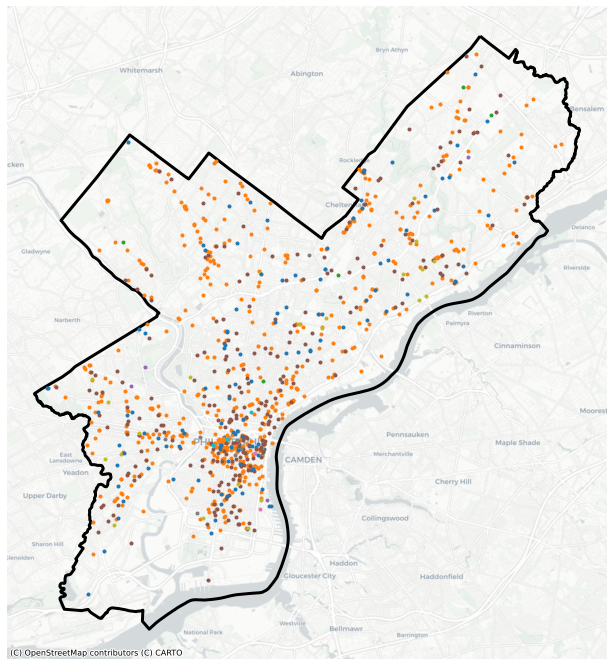

In [35]:

# create the axes
fig, ax = plt.subplots(figsize=(12, 12))

# add the city limits
city_limits.to_crs(clusters.crs).plot(ax=ax, edgecolor='black', linewidth=3, facecolor='none')

# plot a random sample of potholes
groups = clusters.sample(1000).groupby('cluster')
for name, group in groups:
    group.plot(ax=ax, marker='.')

# NEW: plot the basemap underneath
ctx.add_basemap(ax=ax, crs=clusters.crs, url=ctx.providers.CartoDB.Positron)

# remove axis lines
ax.set_axis_off()

## Investigating Small Clusters

In [36]:
clusters.head()

,safegraph_place_id,cluster,latitude,longitude,brands,top_category,Coordinates,index_right,OBJECTID,Shape__Are,Shape__Len
0,sg:00018e7b1ba449278dd1c33a2348e5fa,1,40.106492,-75.029052,NaN,Restaurants and Other Eating Places,POINT (-8352195.863 4881429.496),0,1,0.038911,1.259687
1,sg:0001da921b9d488986c0bdf83bfaff4b,1,40.102114,-75.031340,NaN,"Automotive Parts, Accessories, and Tire Stores",POINT (-8352450.562 4880792.322),0,1,0.038911,1.259687
2,sg:0003e5a379604393b0dc6e9bce0058b2,5,39.982305,-75.239359,Little Caesars,Restaurants and Other Eating Places,POINT (-8375607.131 4863371.223),0,1,0.038911,1.259687
3,sg:0004189674c64e108e4b5ea2baa68eb9,1,39.924732,-75.169153,Popeyes Louisiana Kitchen,Restaurants and Other Eating Places,POINT (-8367791.835 4855010.560),0,1,0.038911,1.259687
4,sg:0008547f38f54091836959120205256c,10,39.974429,-75.141649,NaN,Elementary and Secondary Schools,POINT (-8364730.104 4862227.067),0,1,0.038911,1.259687


In [42]:
philly_patterns_all = pd.read_csv(
        DATA_DIR / "processed" / "philly_patterns.csv.tar.gz", low_memory=False
    )

In [43]:
philly_patterns_all["date_range_start"] = pd.to_datetime(
    philly_patterns_all["date_range_start"].astype(str).apply(lambda x: x[:10])
)

philly_patterns_all["date_range_end"] = pd.to_datetime(
    philly_patterns_all["date_range_end"].astype(str).apply(lambda x: x[:10])
)

In [44]:
philly_patterns_all = philly_patterns_all[
    ['safegraph_place_id', 'date_range_start', 'raw_visit_counts']
]

In [45]:
philly_patterns_all = philly_patterns_all.merge(clusters, on = 'safegraph_place_id')

In [46]:
philly_patterns_all.head()

,safegraph_place_id,date_range_start,raw_visit_counts,cluster,latitude,longitude,brands,top_category,Coordinates,index_right,OBJECTID,Shape__Are,Shape__Len
0,sg:26825b56c5ce4c7d91afdc71a7c34440,2020-10-01,7,1,39.949304,-75.163015,NaN,Electronics and Appliance Stores,POINT (-8367108.556 4858578.007),0,1,0.038911,1.259687
1,sg:26825b56c5ce4c7d91afdc71a7c34440,2020-09-01,5,1,39.949304,-75.163015,NaN,Electronics and Appliance Stores,POINT (-8367108.556 4858578.007),0,1,0.038911,1.259687
2,sg:26825b56c5ce4c7d91afdc71a7c34440,2020-06-01,1,1,39.949304,-75.163015,NaN,Electronics and Appliance Stores,POINT (-8367108.556 4858578.007),0,1,0.038911,1.259687
3,sg:26825b56c5ce4c7d91afdc71a7c34440,2020-08-01,5,1,39.949304,-75.163015,NaN,Electronics and Appliance Stores,POINT (-8367108.556 4858578.007),0,1,0.038911,1.259687
4,sg:26825b56c5ce4c7d91afdc71a7c34440,2020-07-01,1,1,39.949304,-75.163015,NaN,Electronics and Appliance Stores,POINT (-8367108.556 4858578.007),0,1,0.038911,1.259687


In [66]:
def percentile(n):
    def percentile_(x):
        return x.quantile(n/100)
    percentile_.__name__ = 'percentile {}'.format(n)
    return percentile_

In [56]:
np.percentile(philly_patterns_all.raw_visit_counts, 25)

29.0

In [67]:
philly_patterns_all.raw_visit_counts.agg(percentile(25))

29.0

In [71]:
philly_percentiles = philly_patterns_all.groupby('date_range_start').raw_visit_counts.agg([np.mean, percentile(25), percentile(75) ]).reset_index()

In [72]:
philly_percentiles 

,date_range_start,mean,percentile 25,percentile 75
0,2019-01-01,330.410235,37,332.00
1,2019-02-01,322.451800,35,310.00
2,2019-03-01,361.072757,41,356.00
3,2019-04-01,375.552951,42,368.00
4,2019-05-01,365.789936,43,365.00
5,2019-06-01,320.137675,38,311.00
6,2019-07-01,288.714684,36,294.00
7,2019-08-01,346.979813,37,308.00
8,2019-09-01,409.726822,44,375.00
9,2019-10-01,321.198911,39,337.00


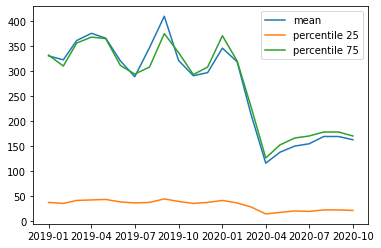

In [80]:
plt.plot('date_range_start', 'mean', data=philly_percentiles)
plt.plot('date_range_start', 'percentile 25', data=philly_percentiles)
plt.plot('date_range_start', 'percentile 75', data=philly_percentiles)
# show legend
plt.legend()

# show graph
plt.show()